# Execute each of these cells but don't change anything until instructed to do so a bit further down

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
pca = PCA()

mpl.rcParams.update({'font.size':16})

# A function for plotting 3-dimensional data
def plot3d(df):
    data = df.values
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*data[:,0:3].T)
    minn,maxx = data.min(),data.max()
    ax.set_xlim(minn,maxx)
    ax.set_ylim(minn,maxx)
    ax.set_zlim(minn,maxx)
    ax.set_xlabel(df.columns[0],labelpad=10)
    ax.set_ylabel(df.columns[1],labelpad=10)
    ax.set_zlabel(df.columns[2],labelpad=10)
    ax.dist = 12
    plt.tight_layout()
        
# A function for summarizing covariancs and correlations
def summarize(info,name,quiet=False):
    values = info[name]
    if not quiet:
        print(values.round(2))
    plt.pcolor(values,cmap='RdBu_r',vmin=-values.max(),vmax=values.max())
    raynge = np.arange(values.shape[0])
    if not quiet:
        plt.xticks(raynge+0.5,raynge)
        plt.yticks(raynge+0.5,raynge)
    else:
        plt.xticks([])
        plt.yticks([])
    plt.gca().invert_yaxis() # Make y-axis go from low to high like a matrix
    plt.colorbar().set_label(name)
    if not quiet:
        eigenvalues,_ = np.linalg.eig(info[name])
        for i,eig in enumerate(sorted(eigenvalues,reverse=True)):
            print('Eigenvalue #%d is %.3g' % (i+1,eig))
        
def report_mean_var(data):
    for i in range(data.shape[1]):
        column = data[:,i]
        print("Dimension %d has mean %.2g and variance %.3g" % \
              (i+1,column.mean(),column.var()))

my_fake_data = np.random.rand(100,3)
my_fake_data[:,2] = (my_fake_data[:,0] + my_fake_data[:,1])/np.sqrt(2)

## In the next cell load your data into a data frame called 'df', i.e. replace the expression on the right-hand side of the equals sign with a command to load whatever data source you want.  Alternatively you could create fake data.  
### It should have 3 or more columns and ideally 10 or more rows.  

In [3]:
df = pd.DataFrame(my_fake_data,
                  index=['Observation %d' % (i+1) for i in range(my_fake_data.shape[0])],
                  columns=['Measurement X','Measurement Y','Measurement Z']) 
                  # Replace the expression above with your something that loads or creates your data 
                  # and puts it into the variable df
df.head()

,Measurement X,Measurement Y,Measurement Z
Observation 1,0.763637,0.366799,0.799339
Observation 2,0.749170,0.095322,0.597146
Observation 3,0.708534,0.313299,0.722545
Observation 4,0.891438,0.789484,1.188591
Observation 5,0.200561,0.280488,0.340153


## If you have loaded your data correctly, and it contains no Infs, NaNs, or rows or columns with zero variance, you should be able to execute the remaining cells without changing anything.  Do so.  

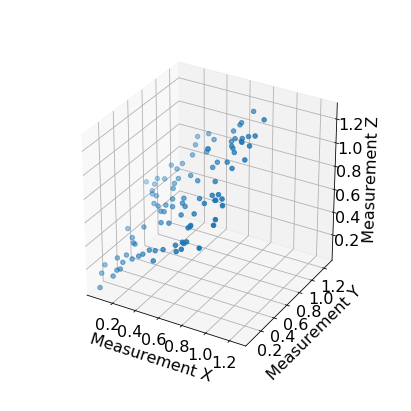

In [4]:
# This will make an interactive plot of the first three dimensions (columns) of your data.  
# In the dummy example, the data should look like a sheet (2-dimensional) cutting through 3-dimensional space.  
# In the data you use, it may look like nothing in particular unless you first three dimensions (measurements)
# are highly correlated as in the dummy example.  
plot3d(df)

## Apply PCA in order to pack as much of the variance of your data-set into two dimensions
### The transformed data will have new dimensions (PC1, PC2, etc. where PC stands for "principal component"
### In the dummy example, the values for PC3 will all be very close to zero.  In your data, they won't necessarily be.  

In [5]:
df_transformed = df.copy()
df_transformed.columns = ['PC %d' % (i+1) for i in range(df.shape[1])]
df_transformed[:] = pca.fit_transform(df.values)
df_transformed.head()

,PC 1,PC 2,PC 3
Observation 1,-0.110685,0.256047,5.495749e-16
Observation 2,0.179022,0.431722,5.542425e-16
Observation 3,-0.002130,0.252628,3.570227e-16
Observation 4,-0.665437,0.059167,4.432326e-16
Observation 5,0.531462,-0.094672,3.934170e-16


## Each of these principal components is a linear combination of the old dimensions (the old measurements)
### Together, they form a rotation matrix that rotates the data from the old coordinate system (where the original measurments form the X, Y, Z, etc. axes) to the new coorindate system (where PC1, PC2, PC3, ... form the X, Y, Z,... axes).  

In [6]:
# This is a matrix that can be used to rotate the data from the old to the new coordinate system
print(pca.components_)

[[-0.48500478 -0.51477365 -0.70695011]
 [ 0.71747499 -0.69642522  0.01488443]
 [-0.5        -0.5         0.70710678]]


## Mathematically, it is a simple matrix multiplication problem
## $ A x R = A' $
### A is the original data, R is the rotation matrix formed by the principal componets, A' is the transformed data
### In the transformed data, the directions that has the most of the variance will have been rotated to line up with the X-axis, the second most with the Y-axis, etc.  

## Here we can show graphically that the left-hand side of that expression equals the right-hand side

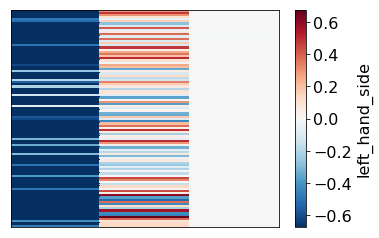

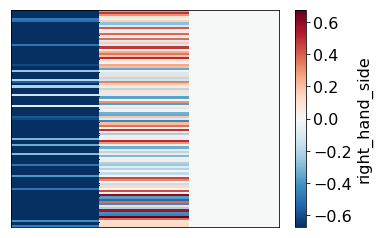

In [7]:
# Technically, you may need to subtract the mean from each row and column for this to be precisely true
df_clean = df.sub(df.mean())
pca.fit(df_clean)

# Define some terms
matrix_multiply = np.dot
rotation_matrix = pca.components_.T
original_data = df.values

# Implement the left-hand and right-hand side of the equation above (AxR = A')
transformed = {}
transformed['left_hand_side'] = matrix_multiply(original_data,rotation_matrix)
transformed['right_hand_side'] = pca.transform(df.values)

# Plot the expressions on the left-hand side and the right-hand side
# These plots should look the same
summarize(transformed,'left_hand_side',quiet=True)
plt.figure()
summarize(transformed,'right_hand_side',quiet=True)

## That rotation matrix tells us what direction the new axes point in:

In [8]:
rotation_df = pd.DataFrame(rotation_matrix,index=df.columns,columns=['PC %d' % (i+1) for i in range(df.shape[1])])
rotation_df

,PC 1,PC 2,PC 3
Measurement X,-0.485005,0.717475,-0.500000
Measurement Y,-0.514774,-0.696425,-0.500000
Measurement Z,-0.706950,0.014884,0.707107


### The first principal component (i.e. the first new axis) points in the following direction (it is a vector with this much of each of the original measurments/dimensions in it)

In [9]:
rotation_df['PC 1']

Measurement X   -0.485005
Measurement Y   -0.514774
Measurement Z   -0.706950
Name: PC 1, dtype: float64

## In the transformed data (which is just the original data, rotated through a high-dimensional space), most of the variance should now be in the first few dimensions.  
### You will see a descending series of percentages.  Depending on the data you pick, the first few dimensions might add up to >95% of the total variance.  

In [10]:
for i in range(pca.n_components_):
    print("PC %d explains %.2g%% of the variance" % (i,100*pca.explained_variance_ratio_[i]))

PC 0 explains 71% of the variance
PC 1 explains 29% of the variance
PC 2 explains 1.3e-30% of the variance


## Plot the first two dimensions, which should have a lot of the variance, i.e. most of what is interesting about the data.  As before, each data point is one observation, but it is now plotted using the new dimensions (and only the first two).  

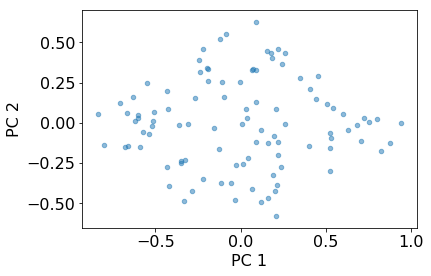

In [11]:
df_transformed.plot.scatter(x='PC 1', y='PC 2', alpha=0.5);

## You might even label your observations in this plot, and see if any patterns emerge

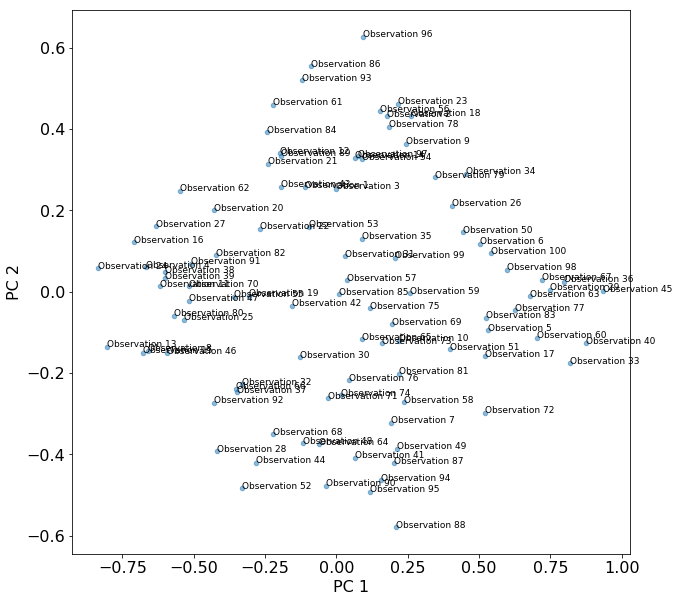

In [12]:
ax = df_transformed.plot.scatter(x='PC 1', y='PC 2', alpha=0.5, figsize=(10,10))
for i, txt in enumerate(df.index):
    x_loc = df_transformed['PC 1'].iloc[i]
    y_loc = df_transformed['PC 2'].iloc[i]
    ax.annotate(txt, (x_loc,y_loc), fontsize=9)

## Did you learn anything about your dataset?  